In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

import tensiometer

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy.stats

from getdist import MCSamples, plots

# Test splines

In [67]:
x = np.random.normal(size=13000)
x = x + np.cos(x)/2.
x = np.concatenate([x, np.random.normal(loc=-1, scale=.25, size=7000)])
y = np.arccos(np.random.uniform(size=len(x)))
X = np.stack([x,y]).T

chain = MCSamples(samples=X, names=['x', 'y'], loglikes=np.ones(len(y)), ranges={'x':[-5,5], 'y':[0,np.pi/2.]})

In [57]:
rqs = tensiometer.synthetic_probability.trainable_bijectors.trainable_ndim_spline_bijector_helper(2, 16, range_min=-3., range_max=3.)

diff = tensiometer.synthetic_probability.DiffFlowCallback(chain, trainable_bijector=rqs, alpha_lossv=1.0, feedback=5)
diff2 = tensiometer.synthetic_probability.DiffFlowCallback(chain, trainable_bijector='MAF', alpha_lossv=1.0, feedback=5)

Weight of density loss: 1, weight of likelihood-loss: 0
Gaussian density loss asymptotic constant: 2.838
Building training/test samples
    - 18000/2000 training/test samples and uniform weights.
Maximum learning rate: 0.001
Building flow
    - trainable parameters: 94
Weight of density loss: 1, weight of likelihood-loss: 0
Gaussian density loss asymptotic constant: 2.838
Building training/test samples
    - 18000/2000 training/test samples and uniform weights.
Building MAF
    - number of MAFs: 4
    - activation: <function asinh at 0x14a999700>
    - hidden_units: [4, 4]
Maximum learning rate: 0.001
Building flow
    - trainable parameters: 208


In [58]:
diff.model.predict(diff.samples_test[:3])

2022-04-07 11:31:30.496234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


array([-2.737174 , -2.0882783, -5.102763 ], dtype=float32)

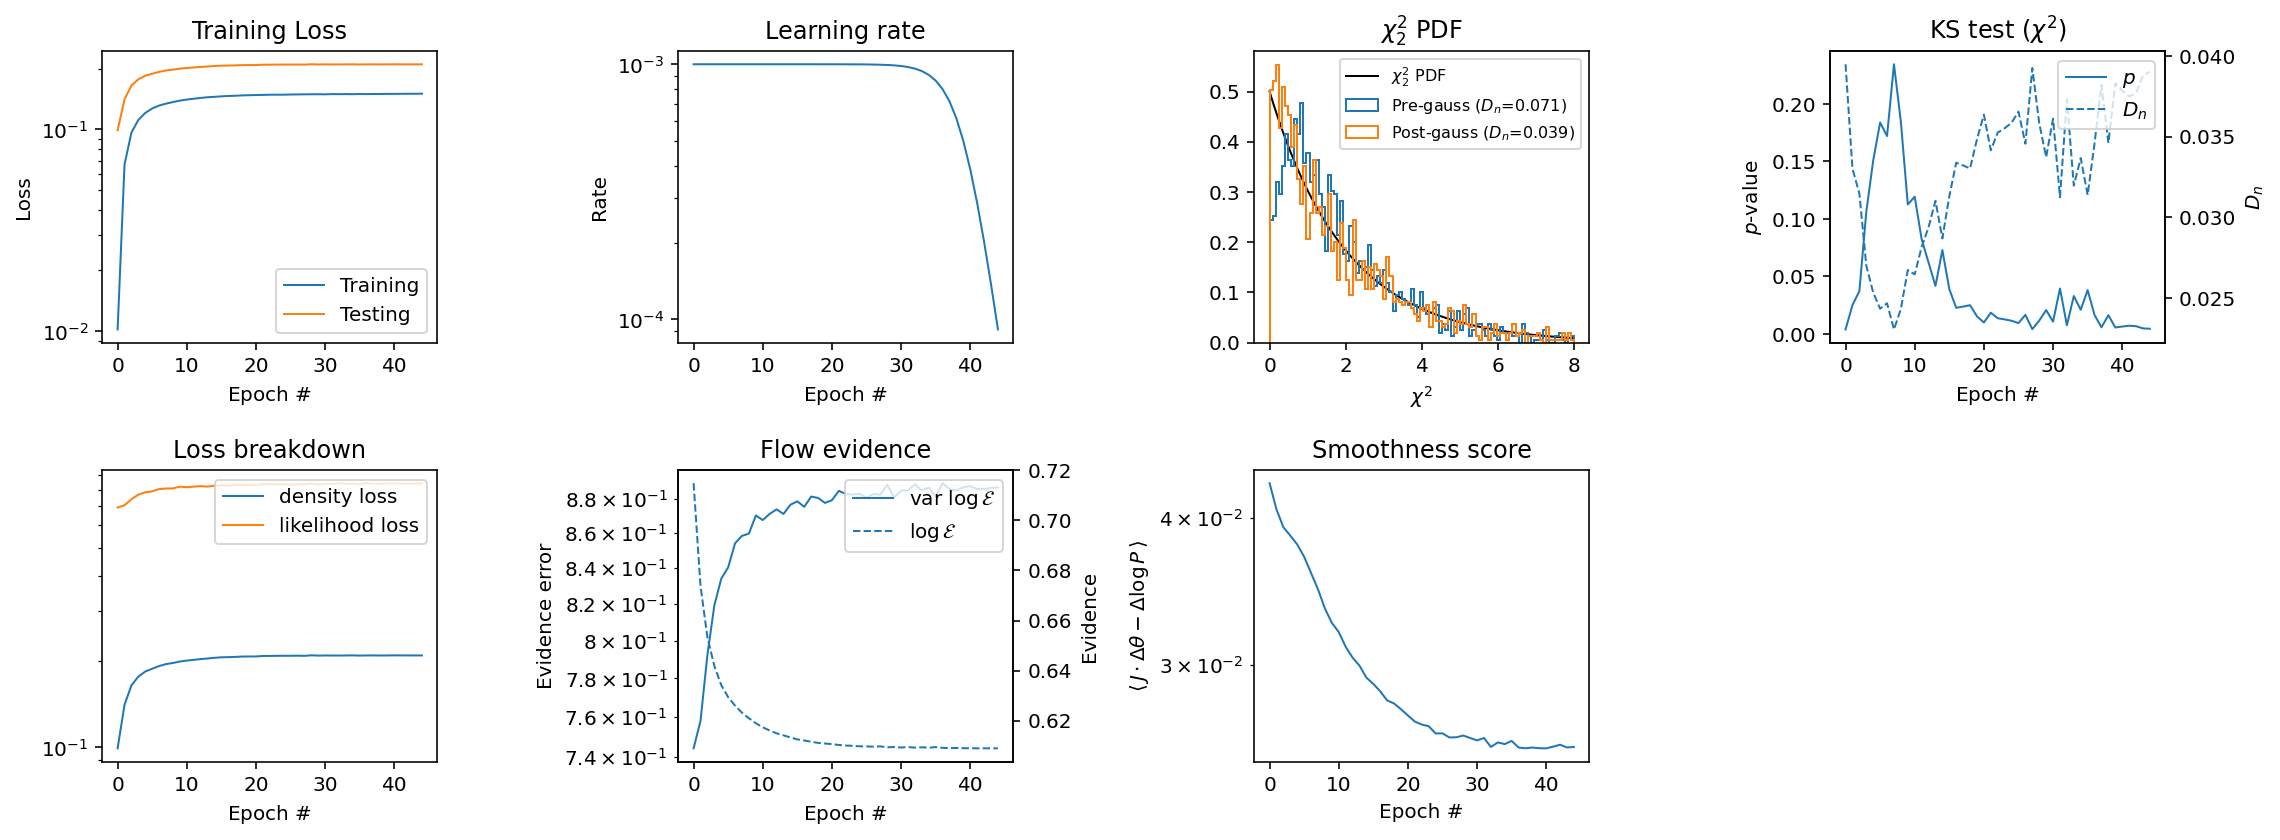

100/100 [==============================] - 11s 108ms/step - loss: -0.1502 - val_loss: -0.2099 - lr: 9.1325e-05 - rho_loss: -0.2099 - like_loss: 0.8413 - chi2Z_ks: 0.0390 - chi2Z_ks_p: 0.0044 - evidence: 0.6089 - evidence_error: 0.8865 - smoothness_score: 0.0255
Epoch 46/50
100/100 [==============================] - 10s 100ms/step - loss: -0.1502 - val_loss: -0.2099 - lr: 5.9689e-05 - rho_loss: -0.2099 - like_loss: 0.8408 - chi2Z_ks: 0.0388 - chi2Z_ks_p: 0.0048 - evidence: 0.6089 - evidence_error: 0.8861 - smoothness_score: 0.0255
Epoch 47/50
100/100 [==============================] - 10s 100ms/step - loss: -0.1502 - val_loss: -0.2099 - lr: 3.8546e-05 - rho_loss: -0.2099 - like_loss: 0.8411 - chi2Z_ks: 0.0388 - chi2Z_ks_p: 0.0048 - evidence: 0.6089 - evidence_error: 0.8863 - smoothness_score: 0.0255
Epoch 48/50
100/100 [==============================] - 11s 106ms/step - loss: -0.1502 - val_loss: -0.2099 - lr: 2.4696e-05 - rho_loss: -0.2099 - like_loss: 0.8410 - chi2Z_ks: 0.0386 - chi2Z_

In [59]:
diff.train(epochs=50)

In [60]:
H, xedges, yedges = np.histogram2d(*diff.sample(100000).numpy().T, bins=50)
xmid = 0.5*(xedges[1:]+xedges[:-1])
ymid = 0.5*(yedges[1:]+yedges[:-1])

2022-04-07 11:41:04.354149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


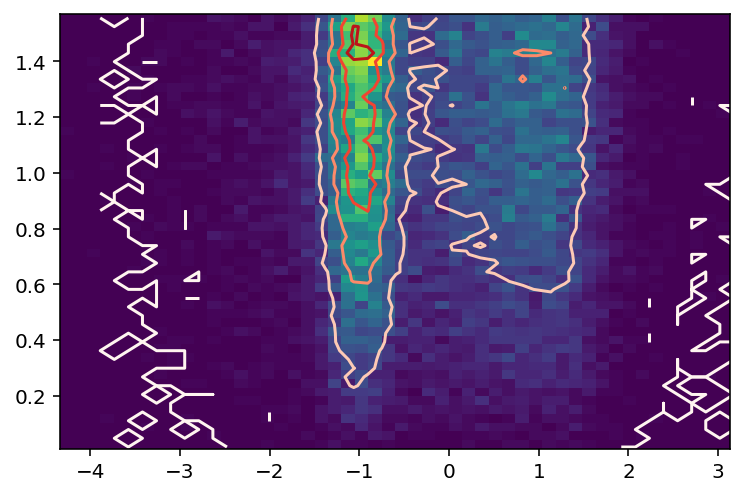

In [61]:
plt.hist2d(*X.T, bins=50);
plt.contour(xmid, ymid, H.T, levels=5, cmap=mpl.cm.Reds)

In [62]:
s = diff.MCSamples(20000)

2022-04-07 11:41:07.696940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-07 11:41:10.107663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


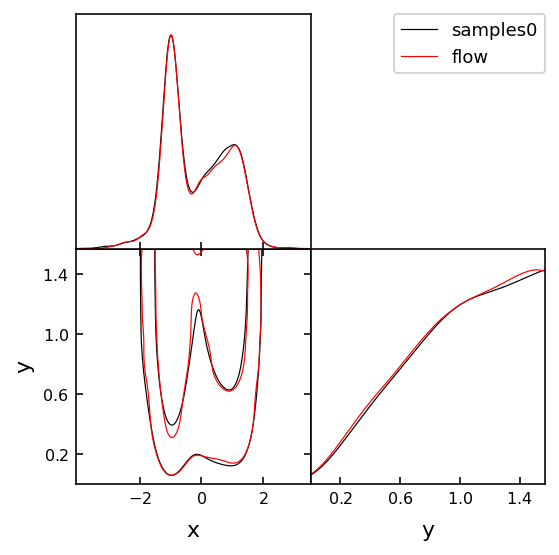

In [63]:
g = plots.get_subplot_plotter()
g.triangle_plot([chain, s])

# Test splines + rotoshift

In [3]:
size = 1000
x = np.random.normal(size=13*size)
x = x + np.cos(x)/2.
x = np.concatenate([x, np.random.normal(loc=-1, scale=.25, size=7*size)])
y = np.arccos(np.random.uniform(size=len(x)))
X = np.stack([x,y]).T

theta = np.radians(30)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))
shift = np.array([1.,2.])
scale = np.diag([0.5,3.])

X = np.dot(np.dot(scale, R),X.T).T + shift

chain = MCSamples(samples=X, names=['x', 'y'],
                  loglikes=np.ones(len(y)),
                  # ranges={'x':[-5,5], 'y':[0,np.pi/2.]}
                 )

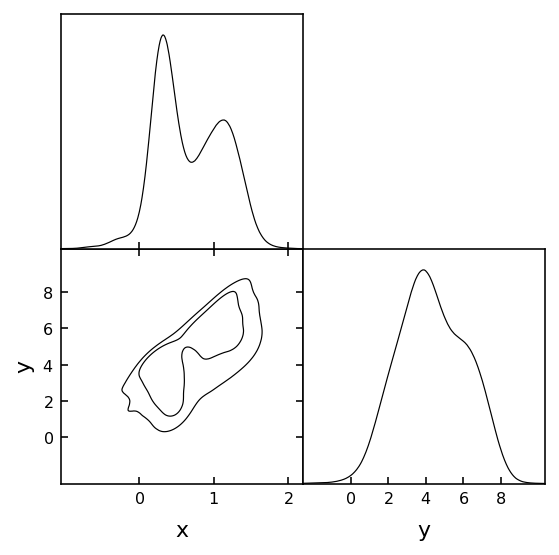

In [4]:
g = plots.get_subplot_plotter()
g.triangle_plot([chain])

In [5]:
rqs = tensiometer.synthetic_probability.trainable_bijectors.trainable_ndim_spline_bijector_helper(2, 16, range_min=-3., range_max=3.)
srs = tensiometer.synthetic_probability.trainable_bijectors.ScaleRotoShift(2)

b = tfb.Chain([rqs, srs])

Metal device set to: Apple M1


2022-04-07 17:02:02.945783: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-07 17:02:02.945910: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
diff = tensiometer.synthetic_probability.FlowCallback(chain, trainable_bijector=b,
                                                          alpha_lossv=1.0, feedback=5)

Weight of density loss: 1, weight of likelihood-loss: 0
Gaussian density loss asymptotic constant: 2.838
Building training/test samples
    - 18000/2000 training/test samples and uniform weights.
Maximum learning rate: 0.001
Building flow
    - trainable parameters: 99


In [7]:
b.trainable_variables

2022-04-07 17:02:05.303486: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


(<tf.Variable 'chain_of_chain_of_invert_split_of_jointmap_of_TQRS0_and_TQRS1_of_split_of_AffineMultivariateNormalDiag/log_prob/chain_of_chain_of_invert_split_of_jointmap_of_TQRS0_and_TQRS1_of_split_of_Affine/inverse/chain_of_invert_split_of_jointmap_of_TQRS0_and_TQRS1_of_split/inverse/jointmap_of_TQRS0_and_TQRS1/inverse/TQRS0/constant:0' shape=(16,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32)>,
 <tf.Variable 'chain_of_chain_of_invert_split_of_jointmap_of_TQRS0_and_TQRS1_of_split_of_AffineMultivariateNormalDiag/log_prob/chain_of_chain_of_invert_split_of_jointmap_of_TQRS0_and_TQRS1_of_split_of_Affine/inverse/chain_of_invert_split_of_jointmap_of_TQRS0_and_TQRS1_of_split/inverse/jointmap_of_TQRS0_and_TQRS1/inverse/TQRS0/constant:0' shape=(16,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32)>,
 <tf.Variable 'chain_of_chain_of_invert_split_of_jointmap_

In [32]:
diff.model.trainable_variables

[<tf.Variable 'chain_of_chain_of_invert_split_of_jointmap_of_TQRS0_and_TQRS1_of_split_of_AffineMultivariateNormalDiag/log_prob/chain_of_chain_of_invert_split_of_jointmap_of_TQRS0_and_TQRS1_of_split_of_Affine/inverse/chain_of_invert_split_of_jointmap_of_TQRS0_and_TQRS1_of_split/inverse/jointmap_of_TQRS0_and_TQRS1/inverse/TQRS0/constant:0' shape=(16,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32)>,
 <tf.Variable 'chain_of_chain_of_invert_split_of_jointmap_of_TQRS0_and_TQRS1_of_split_of_AffineMultivariateNormalDiag/log_prob/chain_of_chain_of_invert_split_of_jointmap_of_TQRS0_and_TQRS1_of_split_of_Affine/inverse/chain_of_invert_split_of_jointmap_of_TQRS0_and_TQRS1_of_split/inverse/jointmap_of_TQRS0_and_TQRS1/inverse/TQRS1/constant:0' shape=(16,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32)>,
 <tf.Variable 'chain_of_chain_of_invert_split_of_jointmap_

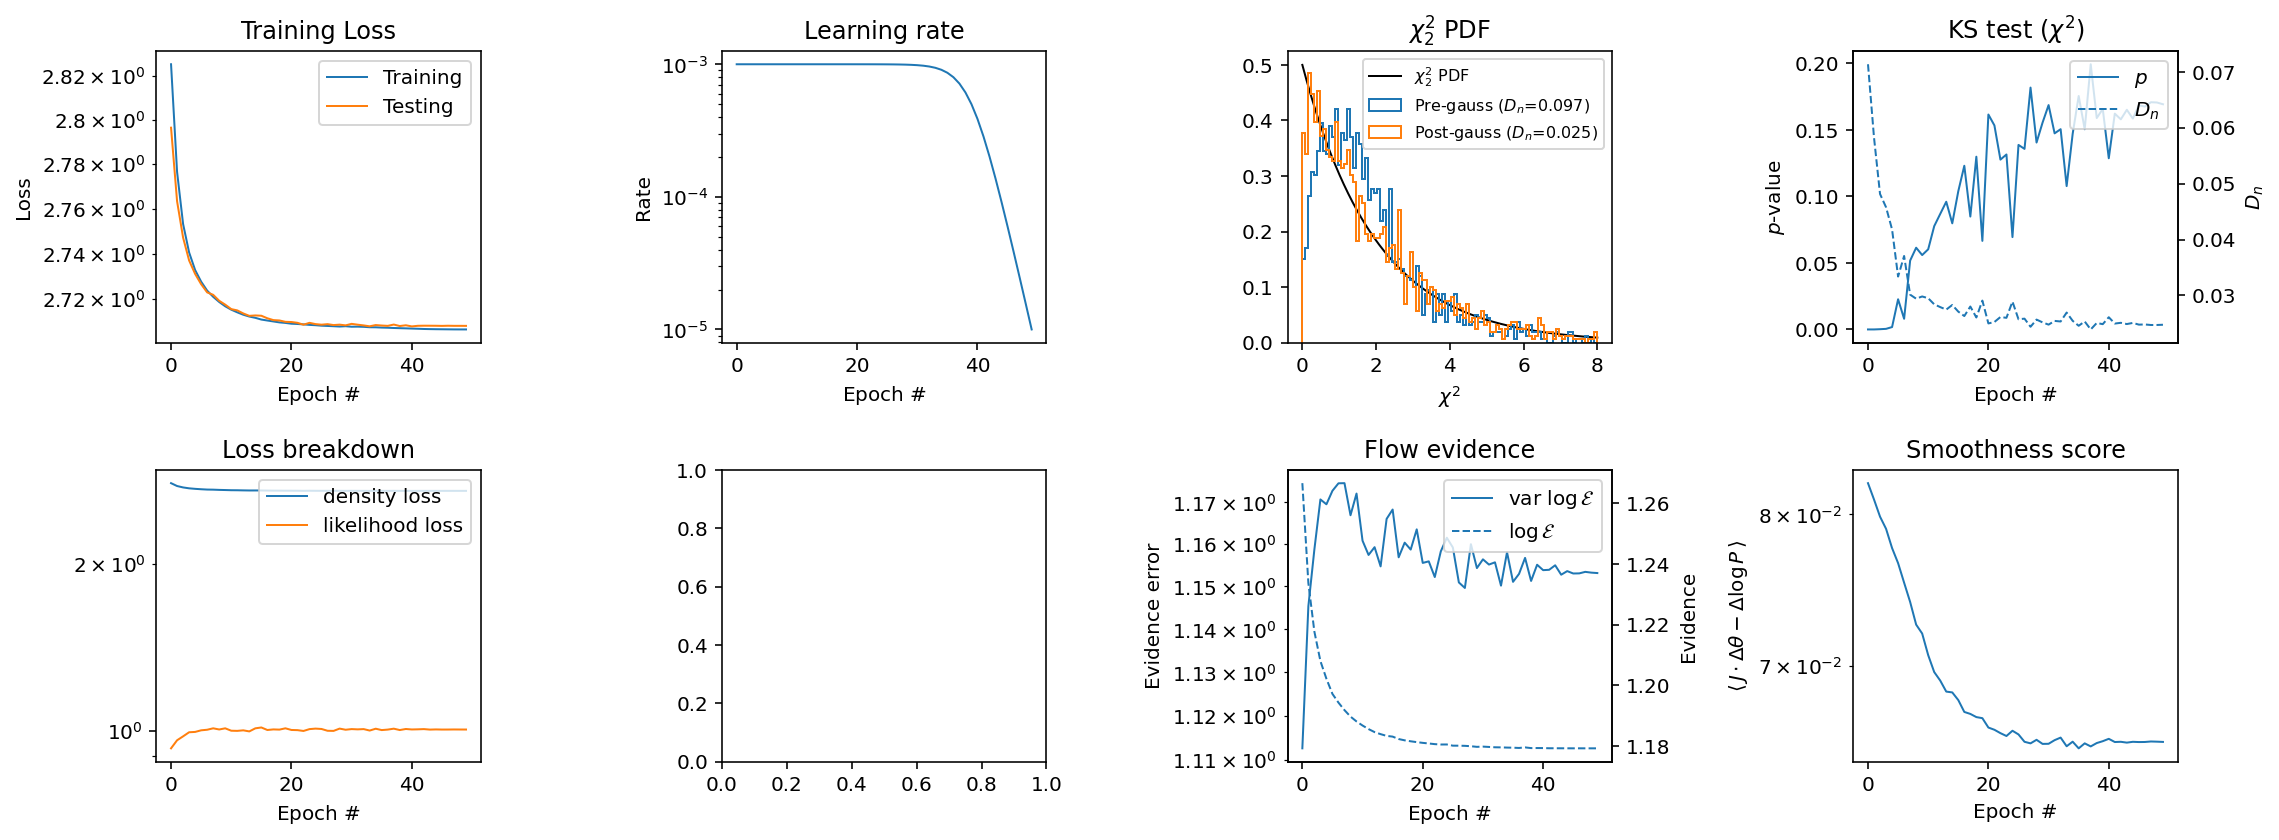

100/100 [==============================] - 15s 151ms/step - loss: 2.7067 - val_loss: 2.7082 - lr: 1.0000e-05 - rho_loss: 2.7082 - like_loss: 1.0044 - chi2Z_ks: 0.0248 - chi2Z_ks_p: 0.1692 - evidence: 1.1793 - evidence_error: 1.1532 - smoothness_score: 0.0655


In [8]:
diff.train(epochs=50)#, batch_size=1000)

In [12]:
s = diff.MCSamples(200000)

2022-04-07 16:34:48.611658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-07 16:34:50.829753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


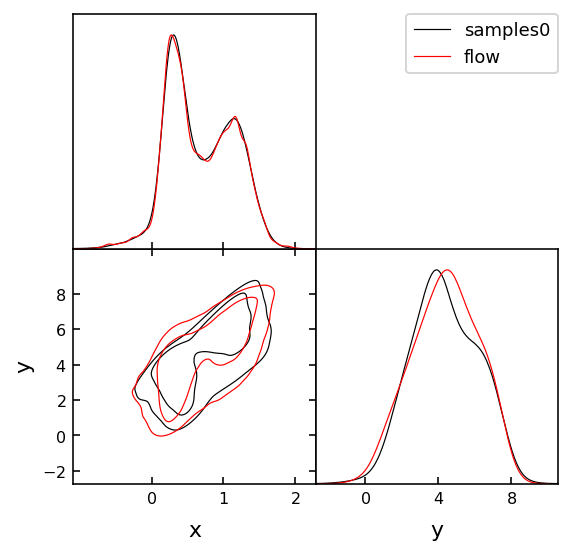

In [13]:
g = plots.get_subplot_plotter()
g.triangle_plot([chain, s])

In [11]:
diff.model.trainable_variables

[<tf.Variable 'chain_of_chain_of_invert_split_of_jointmap_of_TQRS0_and_TQRS1_of_split_of_AffineMultivariateNormalDiag/log_prob/chain_of_chain_of_invert_split_of_jointmap_of_TQRS0_and_TQRS1_of_split_of_Affine/inverse/chain_of_invert_split_of_jointmap_of_TQRS0_and_TQRS1_of_split/inverse/jointmap_of_TQRS0_and_TQRS1/inverse/TQRS0/constant:0' shape=(16,) dtype=float32, numpy=
 array([ 0.19406815,  0.1745923 ,  0.07662841,  0.01890889, -0.2505396 ,
        -0.30978796, -0.12219036,  0.19987588,  0.31160018,  0.07319645,
        -0.08833756, -0.10868359, -0.0733634 , -0.0783899 ,  0.02971371,
         0.10602786], dtype=float32)>,
 <tf.Variable 'chain_of_chain_of_invert_split_of_jointmap_of_TQRS0_and_TQRS1_of_split_of_AffineMultivariateNormalDiag/log_prob/chain_of_chain_of_invert_split_of_jointmap_of_TQRS0_and_TQRS1_of_split_of_Affine/inverse/chain_of_invert_split_of_jointmap_of_TQRS0_and_TQRS1_of_split/inverse/jointmap_of_TQRS0_and_TQRS1/inverse/TQRS1/constant:0' shape=(16,) dtype=float32, n